### Importing Packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import os
plt.style.use('ggplot')

In [2]:
filepath_dict = {'yelp':   '../input/sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.txt',
                 'amazon': '../input/sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt',
                 'imdb':   '../input/sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt'}

dataframe_list = []
for source, filepath in filepath_dict.items():
    dataframe = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    dataframe['source'] = source
    dataframe_list.append(dataframe)

In [3]:
dataframe_list

[                                              sentence  label source
 0                             Wow... Loved this place.      1   yelp
 1                                   Crust is not good.      0   yelp
 2            Not tasty and the texture was just nasty.      0   yelp
 3    Stopped by during the late May bank holiday of...      1   yelp
 4    The selection on the menu was great and so wer...      1   yelp
 5       Now I am getting angry and I want my damn pho.      0   yelp
 6                Honeslty it didn't taste THAT fresh.)      0   yelp
 7    The potatoes were like rubber and you could te...      0   yelp
 8                            The fries were great too.      1   yelp
 9                                       A great touch.      1   yelp
 10                            Service was very prompt.      1   yelp
 11                                  Would not go back.      0   yelp
 12   The cashier had no care what so ever on what I...      0   yelp
 13   I tried the Ca

In [4]:
dataframe = pd.concat(dataframe_list)
dataframe.iloc[0]

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object

In [5]:
dataframe.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [6]:
dataframe.tail()

,sentence,label,source
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb
747,All in all its an insult to one's intelligence...,0,imdb


Now use the `CountVectorizer` provided by the `scikit-learn` library to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words:

In [7]:
sentences = ['Shashant likes ice cream', 'Shashant hates sushi.']

In [8]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'Shashant': 0, 'likes': 4, 'ice': 3, 'cream': 1, 'hates': 2, 'sushi': 5}

In [9]:
vectorizer.transform(sentences).toarray()

array([[1, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 1]])

## Defining a Baseline Model

In [10]:
dataframe_yelp = dataframe[dataframe['source'] == 'yelp']
sentences = dataframe_yelp['sentence'].values
y = dataframe_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [12]:
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [13]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
for source in dataframe['source'].unique():
    dataframe_source = dataframe[dataframe['source'] == source]
    sentences = dataframe_source['sentence'].values
    y = dataframe_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### First Keras Model

In [15]:
#Multi Layer Perceptron(MLP)
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                25060     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Train on 561 samples, validate on 187 samples
Epoch 1/100
561/561 [==============================] - 0s 884us/step - loss: 0.6894 - acc: 0.5472 - val_loss: 0.6947 - val_acc: 0.4706
Epoch 2/100
561/561 [==============================] - 0s 248us/step - loss: 0.6414 - acc: 0.7041 - val_loss: 0.6940 - val_acc: 0.5882
Epoch 3/100
561/561 [==============================] - 0s 269us/step - loss: 0.5681 - acc: 0.8930 - val_loss: 0.6874 - val_acc: 0.6471
Epoch 4/100
561/561 [==============================] - 0s 245us/step - loss: 0.4738 - acc: 0.9305 - val_loss: 0.6474 - val_acc: 0.7273
Epoch 5/100
561/561 [==============================] - 0s 227us/step - loss: 0.3847 - acc: 0.9519 - val_loss: 0.6254 - val_acc: 0.7487
Epoch 6/100
561/561 [==============================] - 0s 234us/step - loss: 0.3071 - acc: 0.9715 - val_loss: 0.5897 - val_acc: 0.7647
Epoch 7/100
561/561 [==============================] - 0s 235us/step - loss: 0.2471 - acc: 0.9804 - val_loss: 0.5667 - val_acc: 0.7754
Epoch 8/1

In [18]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 1.0000
Testing Accuracy:  0.7914


In [19]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

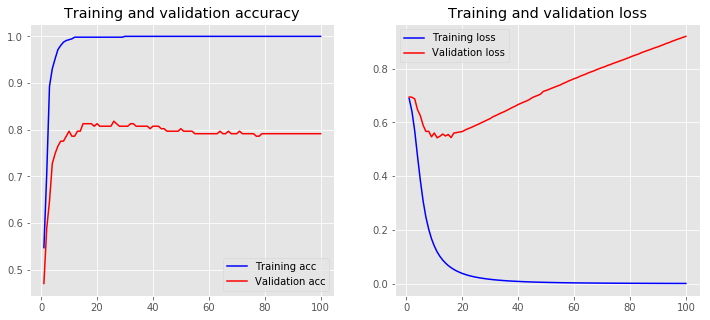

In [20]:
plot_history(history)

In [21]:
cities = ['London', 'Birmingham', 'Birmingham', 'Manchester', 'London']
cities

['London', 'Birmingham', 'Birmingham', 'Manchester', 'London']

In [22]:
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

In [23]:
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

## Word Embeddings


In [24]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


In [25]:
for word in ['the', 'all','fan']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
fan: 932


In [26]:
maxlength = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlength)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlength)

print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


### Keras Embedding Layer

In [27]:
embedding_dimension = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dimension, 
                           input_length=maxlength))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           128750    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 561 samples, validate on 187 samples
Epoch 1/20
561/561 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.5116 - val_loss: 0.6930 - val_acc: 0.5134
Epoch 2/20
561/561 [==============================] - 0s 456us/step - loss: 0.6918 - acc: 0.4724 - val_loss: 0.6930 - val_acc: 0.4920
Epoch 3/20
561/561 [==============================] - 0s 462us/step - loss: 0.6903 - acc: 0.5294 - val_loss: 0.6930 - val_acc: 0.4920
Epoch 4/20
561/561 [==============================] - 0s 425us/step - loss: 0.6889 - acc: 0.5294 - val_loss: 0.6931 - val_acc: 0.4920
Epoch 5/20
561/561 [==============================] - 0s 418us/step - loss: 0.6883 - acc: 0.5294 - val_loss: 0.6932 - val_acc: 0.4920
Epoch 6/20
561/561 [==============================] - 0s 470us/step - loss: 0.6879 - acc: 0.5294 - val_loss: 0.6933 - val_acc: 0.4920
Epoch 7/20
561/561 [==============================] - 0s 496us/step - loss: 0.6877 - acc: 0.5294 - val_loss: 0.6934 - val_acc: 0.4920
Epoch 8/20
561/561

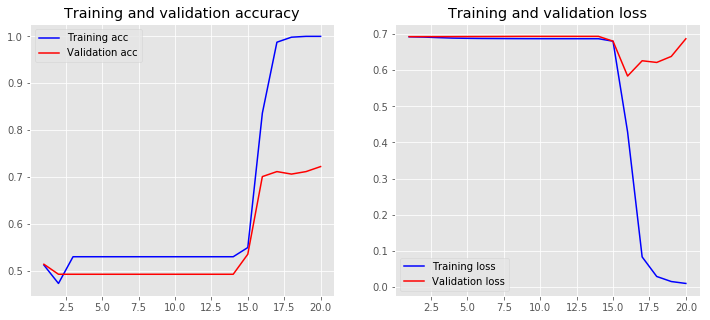

In [28]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

In [29]:
embedding_dimension = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dimension, 
                           input_length=maxlength))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7914


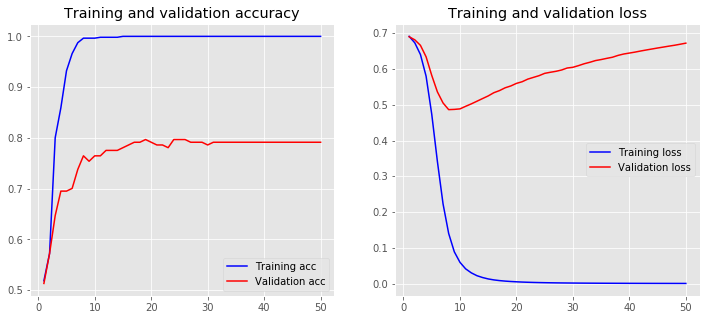

In [30]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Convolutional Neural Networks (CNN)

In [31]:
embedding_dimension = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dimension, input_length=maxlength))

model.add(layers.Conv1D(256, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          257500    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7540


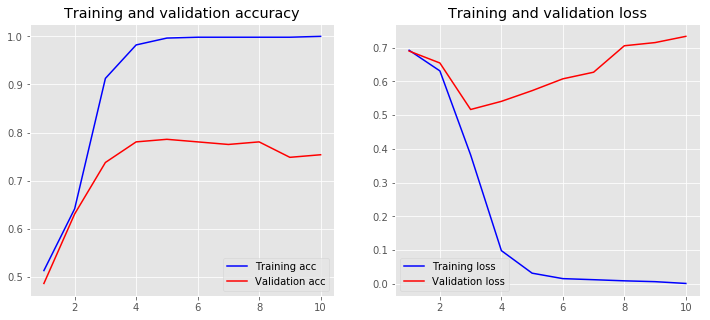

In [32]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Hyperparameters Optimization

In [37]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dimension, maxlength):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dimension, input_length=maxlength))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [38]:
parameter_grid = dict(num_filters=[32, 64, 128, 256],
                  kernel_size=[3, 5, 7, 9],
                  vocab_size=[5000], 
                  embedding_dimension=[50],
                  maxlength=[100])

In [39]:
# Main settings
epochs = 20
embedding_dimension = 50
maxlength = 100
output_file = 'output.txt'

# Running grid search for each source (yelp, amazon, imdb)
for source, frame in dataframe.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = dataframe['sentence'].values
    y = dataframe['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlength)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlength)

    # Parameter grid for grid search
    parameter_grid = dict(num_filters=[32, 64, 128, 256],
                      kernel_size=[3, 5, 7, 9],
                      vocab_size=[vocab_size],
                      embedding_dimension=[embedding_dimension],
                      maxlength=[maxlength])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=parameter_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
#     prompt = input(f'finished {source}; write to file and proceed? [y/n]')
#     if prompt.lower() not in {'y', 'true', 'yes'}:
#         break
#     with open(output_file, 'w+') as f:
    s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        source,
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
#         f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 14.1min finished


Running amazon data set
Best Accuracy : 0.8151
{'vocab_size': 4603, 'num_filters': 64, 'maxlength': 100, 'kernel_size': 3, 'embedding_dimension': 50}
Test Accuracy : 0.8355


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 16.1min finished


Running imdb data set
Best Accuracy : 0.8180
{'vocab_size': 4603, 'num_filters': 128, 'maxlength': 100, 'kernel_size': 3, 'embedding_dimension': 50}
Test Accuracy : 0.8341


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 16.4min finished


Running yelp data set
Best Accuracy : 0.8180
{'vocab_size': 4603, 'num_filters': 32, 'maxlength': 100, 'kernel_size': 7, 'embedding_dimension': 50}
Test Accuracy : 0.8268


